<a href="https://colab.research.google.com/github/terrencee/Finance_Projects/blob/main/AAPL_Beta_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:

import yfinance as yf
import pandas as pd
import statsmodels.api as sm

In [4]:
# Download monthly adjusted close prices
aapl = yf.download("AAPL", start="2010-01-01", end="2023-12-31", interval="1mo")


/tmp/ipython-input-3763324238.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  aapl = yf.download("AAPL", start="2010-01-01", end="2023-12-31", interval="1mo")
[*********************100%***********************]  1 of 1 completed


In [6]:
aapl.columns

MultiIndex([( 'Close', 'AAPL'),
            (  'High', 'AAPL'),
            (   'Low', 'AAPL'),
            (  'Open', 'AAPL'),
            ('Volume', 'AAPL')],
           names=['Price', 'Ticker'])

In [9]:
# Flatten the column names
aapl.columns = aapl.columns.get_level_values(0)
aapl.columns

Index(['Close', 'High', 'Low', 'Open', 'Volume'], dtype='object', name='Price')

In [11]:
aapl = aapl['Close'].dropna()


In [13]:
# getting monthly returns

aapl_returns = aapl.pct_change().dropna()
aapl_returns.name = "AAPL"

In [14]:
# Load Fama-French data
#Reads the Fama-French monthly factors from Kenneth French’s CSV.

# Cleans up the date and converts it to monthly format.

# Extracts Mkt-RF (market premium) and RF (risk-free rate).

ff = pd.read_csv("F-F_Research_Data_Factors.csv", skiprows=3)
ff = ff.rename(columns={"Unnamed: 0": "Date"})
ff = ff[ff["Date"].str.len() == 6]  # Clean footer
ff["Date"] = pd.to_datetime(ff["Date"], format="%Y%m").dt.to_period("M")

# Convert to numeric
ff[["Mkt-RF", "RF"]] = ff[["Mkt-RF", "RF"]].apply(pd.to_numeric)

In [15]:
# Create total market return
ff["Market"] = ff["Mkt-RF"] + ff["RF"]

# Convert AAPL index to period for merge
aapl_returns.index = aapl_returns.index.to_period("M")

In [16]:
ff["Market"]

,Market
0,3.11
1,2.89
2,0.61
3,-2.95
4,2.85
...,...
1183,-2.11
1184,-6.05
1185,-0.49
1186,6.44


In [17]:
aapl_returns.index

PeriodIndex(['2010-02', '2010-03', '2010-04', '2010-05', '2010-06', '2010-07',
             '2010-08', '2010-09', '2010-10', '2010-11',
             ...
             '2023-03', '2023-04', '2023-05', '2023-06', '2023-07', '2023-08',
             '2023-09', '2023-10', '2023-11', '2023-12'],
            dtype='period[M]', name='Date', length=167)

Aligns AAPL returns to monthly period format.

Merges AAPL returns with market premium and risk-free rate.

Calculates AAPL Excess Return = AAPL return – RF.

Multiplies AAPL return by 100 because Mkt-RF and RF are in percentage units (e.g., 1.2 for 1.2%).

In [18]:
# Merge datasets
df = pd.concat([aapl_returns, ff.set_index("Date")[["Mkt-RF", "RF"]]], axis=1).dropna()

# Compute AAPL excess return
df["AAPL_Excess"] = (df["AAPL"] * 100) - df["RF"]

In [20]:
df.head(5)

,AAPL,Mkt-RF,RF,AAPL_Excess
Date,,,,
2010-02,0.065397,3.39,0.00,6.539657
2010-03,0.148470,6.30,0.01,14.837021
2010-04,0.111021,1.99,0.01,11.092111
2010-05,-0.016125,-7.90,0.01,-1.622467
2010-06,-0.020827,-5.56,0.01,-2.092655


    Regresses AAPL excess return (y) on market premium (X).

    Adds a constant (intercept) to estimate alpha.

    Runs OLS regression.

    Prints the full statistical summary.

 Output:

    Alpha = intercept = 1.1603

    Beta = slope (Mkt-RF coef) = 1.0973

In [22]:
# Estimate beta via regression

X = df["Mkt-RF"]
y = df["AAPL_Excess"]

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            AAPL_Excess   R-squared:                       0.387
Model:                            OLS   Adj. R-squared:                  0.383
Method:                 Least Squares   F-statistic:                     104.0
Date:                Wed, 06 Aug 2025   Prob (F-statistic):           3.02e-19
Time:                        14:01:37   Log-Likelihood:                -539.45
No. Observations:                 167   AIC:                             1083.
Df Residuals:                     165   BIC:                             1089.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1603      0.490      2.366      0.0

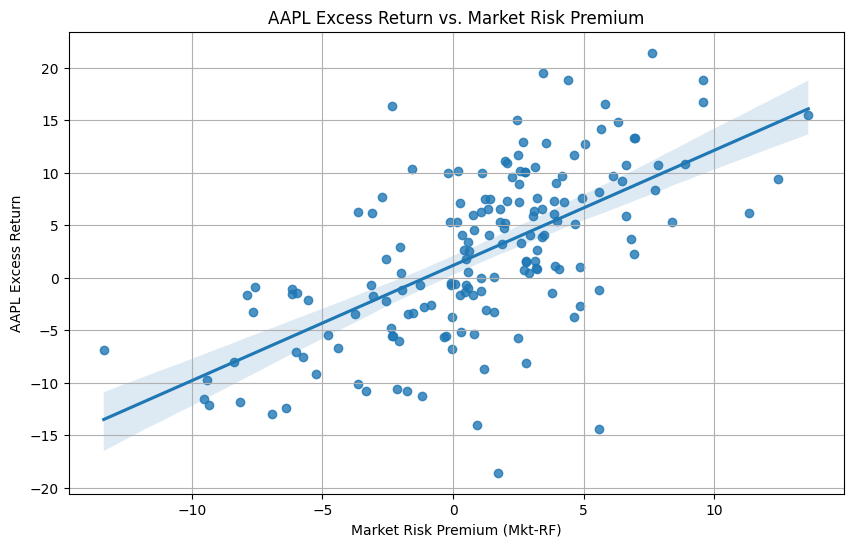

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the data and the regression line
plt.figure(figsize=(10, 6))
sns.regplot(x="Mkt-RF", y="AAPL_Excess", data=df)
plt.xlabel("Market Risk Premium (Mkt-RF)")
plt.ylabel("AAPL Excess Return")
plt.title("AAPL Excess Return vs. Market Risk Premium")
plt.grid(True)
plt.show()